# Heart Disease Prediction

## Question 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from collections import Counter

In [2]:
train_df = pd.read_csv('data/train_val_split.csv')
test_df = pd.read_csv('data/test_split.csv')
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ag

In [11]:
train_df.head(600)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,54,F,NAP,160,201,0,Normal,163,N,0.0,Up,0
596,62,M,ASY,120,267,0,Normal,99,Y,1.8,Flat,1
597,52,F,NAP,136,196,0,LVH,169,N,0.1,Flat,0
598,52,M,ATA,134,201,0,Normal,158,N,0.8,Up,0


In [12]:
cholesterol_zero_count = train_df[train_df['Cholesterol'] == 0].shape[0]
print(f"Number of records with Cholesterol = 0: {cholesterol_zero_count}")

Number of records with Cholesterol = 0: 141


We directly see that all features are present in both the train/validation and the test set (no null values), however some values should be treated as missing (eg Cholesterol has many 0-entries).

In [13]:
print(f"Heart disease variable counts:\n{train_df['HeartDisease'].value_counts()}")
print(f"Heart disease percentage (train/val):\n{train_df['HeartDisease'].value_counts(normalize=True).round(4)}")

Heart disease variable counts:
HeartDisease
1    398
0    336
Name: count, dtype: int64
Heart disease percentage (train/val):
HeartDisease
1    0.5422
0    0.4578
Name: proportion, dtype: float64


We see a roughly even distribution of heart disease (54.2%) vs no-heart-disease records (45.8%). For analyzing the feature value distributions, we distinguish between (continuous) numerical and categorical variables. We further compare them across the two heart disease groups (0 vs 1).

In [14]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target = 'HeartDisease'

In [23]:
print(train_df.describe().round(2))

          Age  RestingBP  Cholesterol  FastingBS   MaxHR  Oldpeak  \
count  734.00     734.00       734.00     734.00  734.00   734.00   
mean    53.52     132.06       197.59       0.23  136.17     0.87   
std      9.42      18.62       108.98       0.42   25.33     1.08   
min     29.00       0.00         0.00       0.00   60.00    -2.00   
25%     47.00     120.00       172.25       0.00  120.00     0.00   
50%     54.00     130.00       222.00       0.00  138.00     0.50   
75%     60.00     140.00       267.00       0.00  155.00     1.50   
max     77.00     200.00       529.00       1.00  195.00     6.20   

       HeartDisease  
count        734.00  
mean           0.54  
std            0.50  
min            0.00  
25%            0.00  
50%            1.00  
75%            1.00  
max            1.00  


In [15]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

In [24]:
def plot_numerical_features(df, features):
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Overall distr. 
        sns.histplot(data=df, x=feature, kde=True, ax=axes[0])
        axes[0].set_title(f'Distribution of {feature} in whole train data', fontsize=14)
        axes[0].set_xlabel(feature, fontsize=12)
        axes[0].set_ylabel('Count', fontsize=12)
        
        # Plot 2: Distribution by heart disease status
        sns.histplot(data=df[df['HeartDisease']==0], x=feature, color='blue', 
                     label='No Heart Disease', kde=True, alpha=0.5, ax=axes[1])
        sns.histplot(data=df[df['HeartDisease']==1], x=feature, color='red', 
                     label='Heart Disease', kde=True, alpha=0.5, ax=axes[1])
        axes[1].set_title(f'Distribution of {feature} by Heart Disease Status', fontsize=14)
        axes[1].set_xlabel(feature, fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(f'analysis_heart/{feature}_distribution.png', dpi=300)
        plt.show()
        
        print(f"Statistics for {feature}:")
        print(df.groupby('HeartDisease')[feature].describe().round(2))
        print("\n")

def plot_categorical_features(df, features):
    for feature in features:
        if feature == 'HeartDisease': 
            continue
            
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        feature_counts = df[feature].value_counts()
        axes[0].pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%', 
                   startangle=90, shadow=True)
        axes[0].axis('equal')  
        axes[0].set_title(f'Overall Distribution of {feature}', fontsize=14)
        
        counts = pd.crosstab(df[feature], df['HeartDisease'])
        counts.columns = ['No Heart Disease', 'Heart Disease']
        counts.plot(kind='bar', ax=axes[1]) # Grouped bar chart
        axes[1].set_title(f'Distribution of {feature} by Heart Disease Status', fontsize=14)
        axes[1].set_xlabel(feature, fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)
        
        for container in axes[1].containers:
            axes[1].bar_label(container, label_type='edge')
            
        plt.tight_layout()
        plt.savefig(f'analysis_heart/{feature}_distribution.png', dpi=300)
        plt.show()
        
        print(f"Contingency table for {feature}:")
        print(counts)
        print("\nPercentage within each category:")
        print(counts.div(counts.sum(axis=1), axis=0).round(3) * 100)
        print("\n")

def plot_target_distribution(df):
    plt.figure(figsize=(10, 6))
    target_counts = df['HeartDisease'].value_counts()
    
    plt.pie(target_counts, labels=['No Heart Disease', 'Heart Disease'], 
            autopct='%1.1f%%', startangle=90, colors=['blue', 'red'], shadow=True) # Pie chart
    plt.axis('equal')
    plt.title('Distribution of Heart Disease in Dataset', fontsize=16)
    plt.tight_layout()
    plt.savefig('analysis_heart/target_distribution.png', dpi=300)
    plt.show()
    
    print("Heart disease distribution:")
    print(f"No Heart Disease (0): {target_counts[0]} samples ({target_counts[0]/len(df)*100:.1f}%)")
    print(f"Heart Disease (1): {target_counts[1]} samples ({target_counts[1]/len(df)*100:.1f}%)")
    print("\n")

# Comparison of numerical features across two HD target groups with boxplots
def plot_numerical_boxplots(df, features):
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='HeartDisease', y=feature, data=df, hue='HeartDisease', palette=['blue', 'red'], legend=False)
        plt.title(f'Comparison of {feature} by Heart Disease Status', fontsize=14)
        plt.xlabel('Heart Disease Status (0=No, 1=Yes)', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f'analysis_heart/{feature}_boxplot.png', dpi=300)
        plt.show()

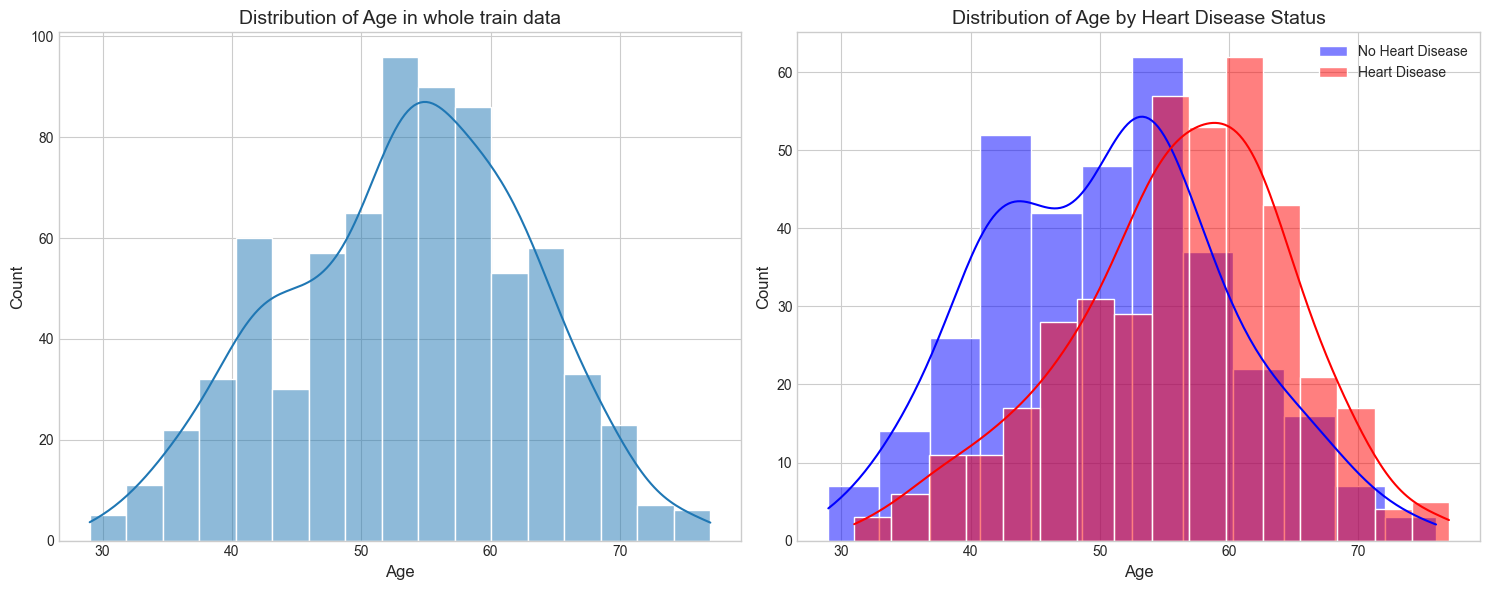

Statistics for Age:
              count   mean   std   min   25%   50%   75%   max
HeartDisease                                                  
0             336.0  50.50  9.33  29.0  43.0  51.0  57.0  76.0
1             398.0  56.07  8.73  31.0  51.0  57.0  62.0  77.0




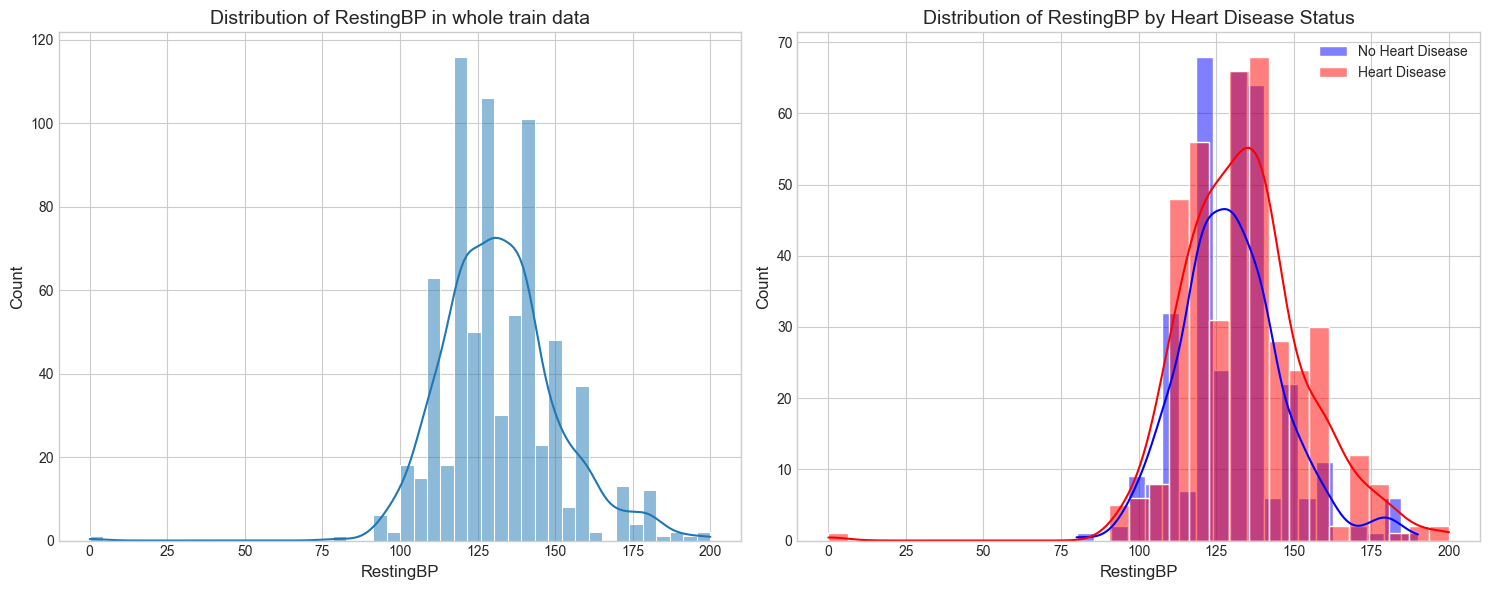

Statistics for RestingBP:
              count    mean    std   min    25%    50%    75%    max
HeartDisease                                                        
0             336.0  130.01  16.59  80.0  120.0  130.0  140.0  190.0
1             398.0  133.80  20.03   0.0  120.0  132.0  144.0  200.0




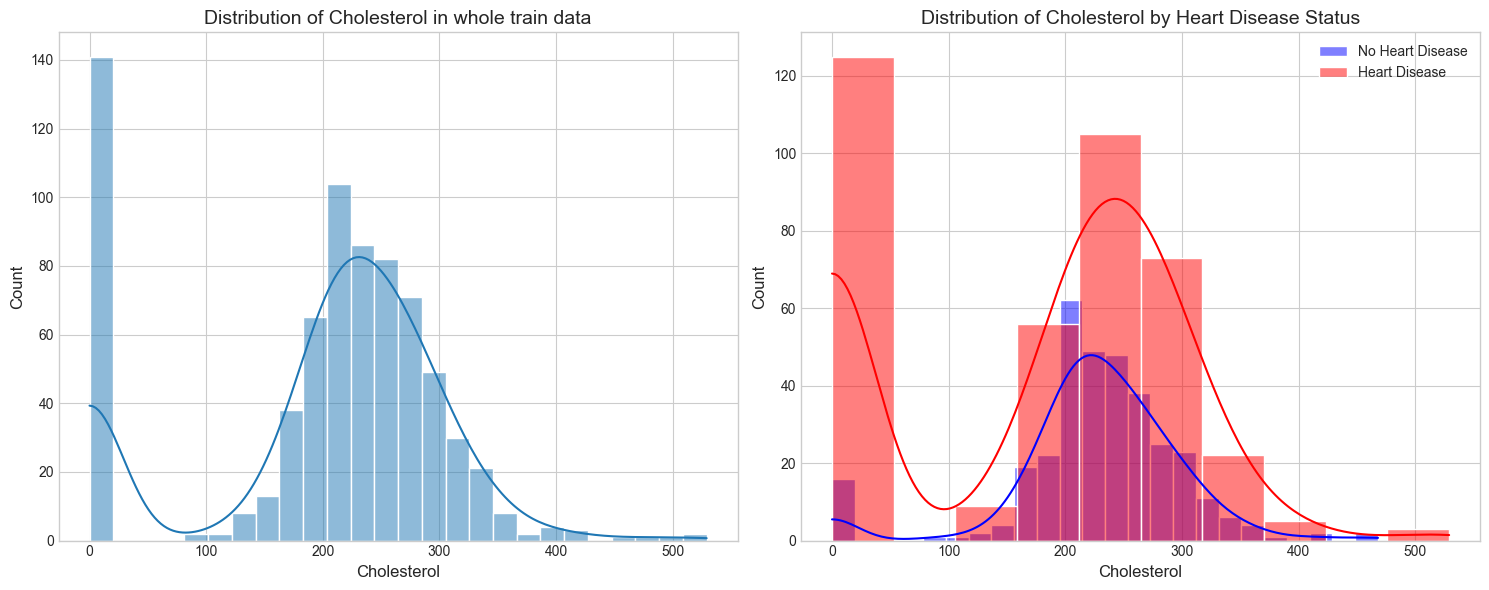

Statistics for Cholesterol:
              count    mean     std  min     25%    50%    75%    max
HeartDisease                                                         
0             336.0  227.64   72.72  0.0  198.75  228.0  268.0  468.0
1             398.0  172.22  126.71  0.0    0.00  216.0  267.0  529.0




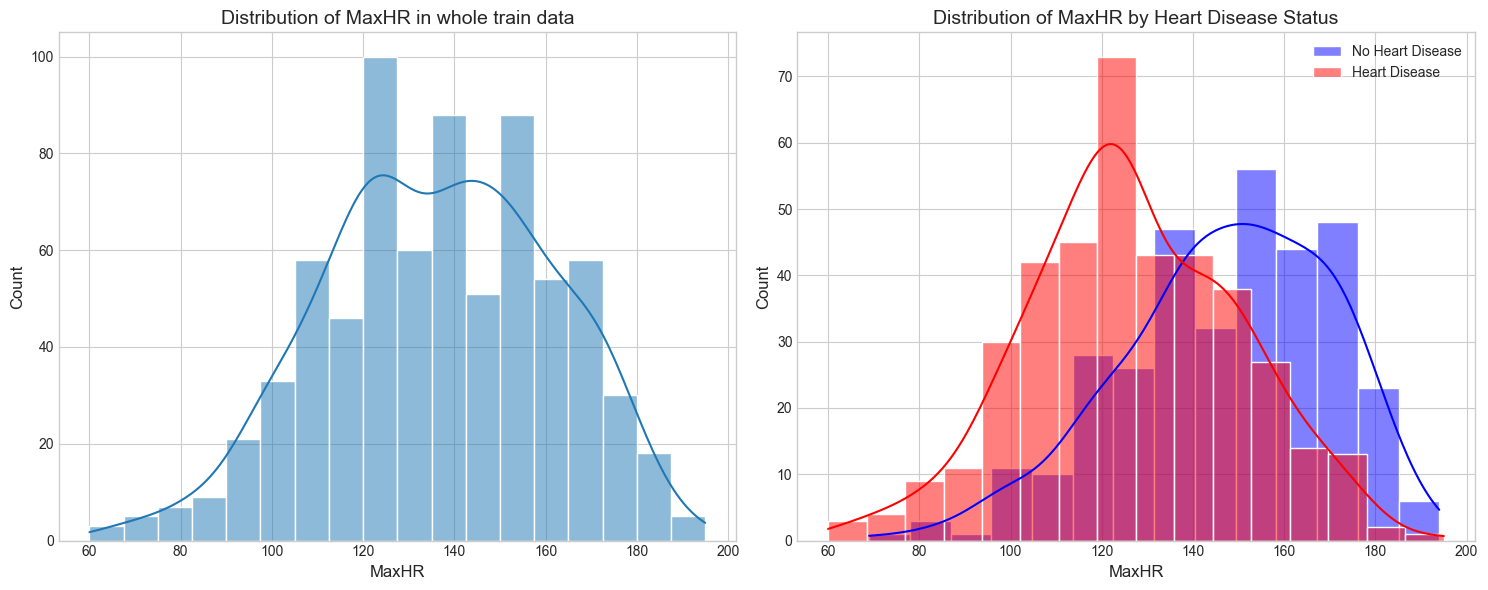

Statistics for MaxHR:
              count    mean    std   min    25%    50%    75%    max
HeartDisease                                                        
0             336.0  147.34  23.00  69.0  133.0  150.0  165.0  194.0
1             398.0  126.73  23.32  60.0  111.0  125.0  143.0  195.0




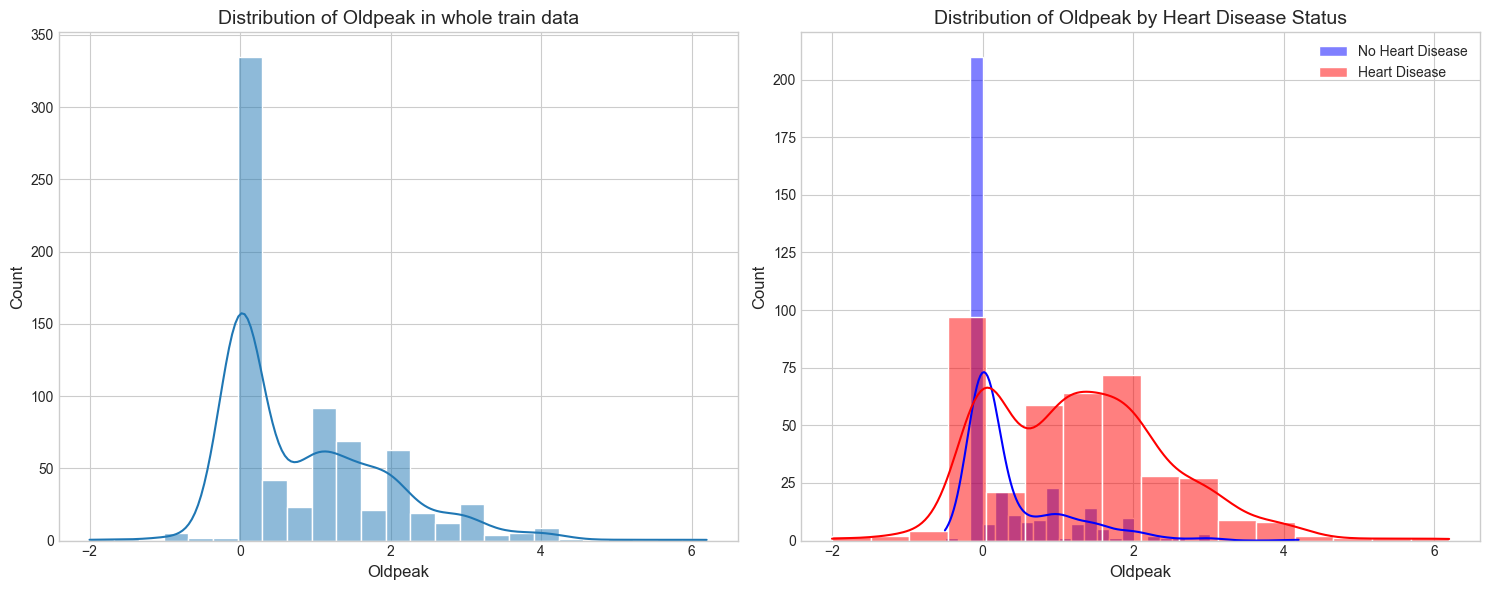

Statistics for Oldpeak:
              count  mean   std  min  25%  50%  75%  max
HeartDisease                                            
0             336.0  0.38  0.67 -0.5  0.0  0.0  0.6  4.2
1             398.0  1.29  1.18 -2.0  0.0  1.2  2.0  6.2




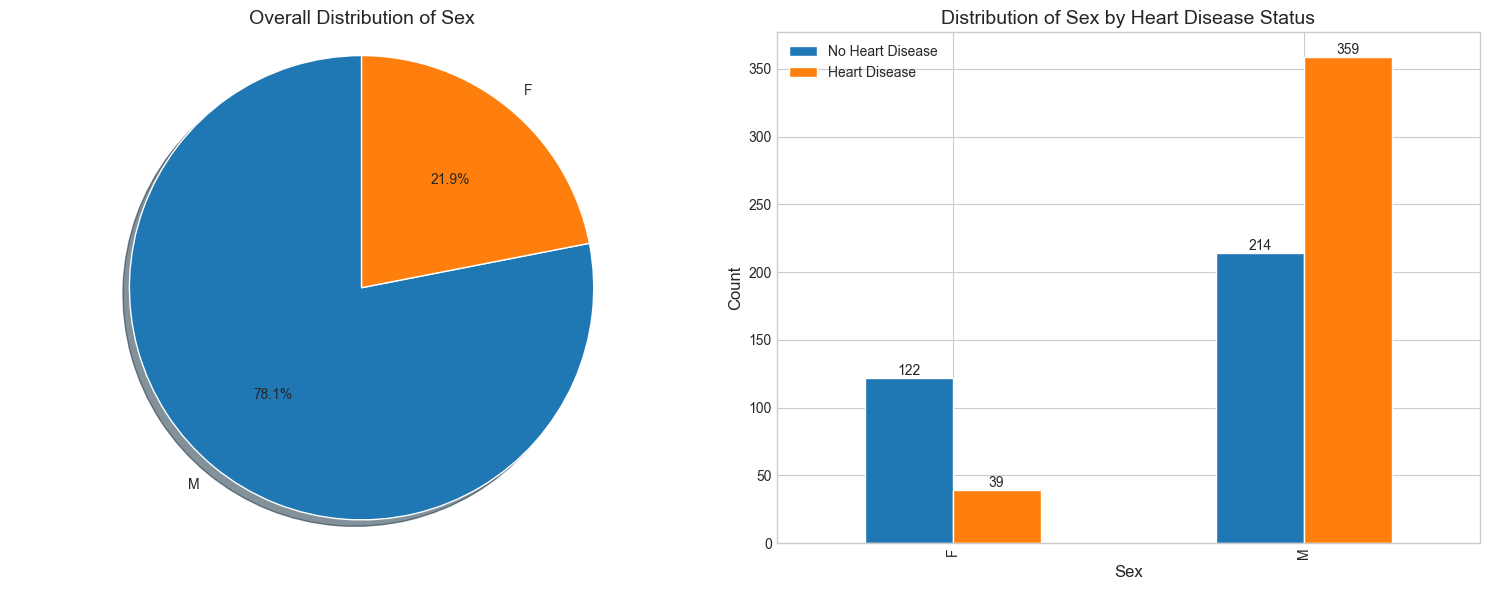

Contingency table for Sex:
     No Heart Disease  Heart Disease
Sex                                 
F                 122             39
M                 214            359

Percentage within each category:
     No Heart Disease  Heart Disease
Sex                                 
F                75.8           24.2
M                37.3           62.7




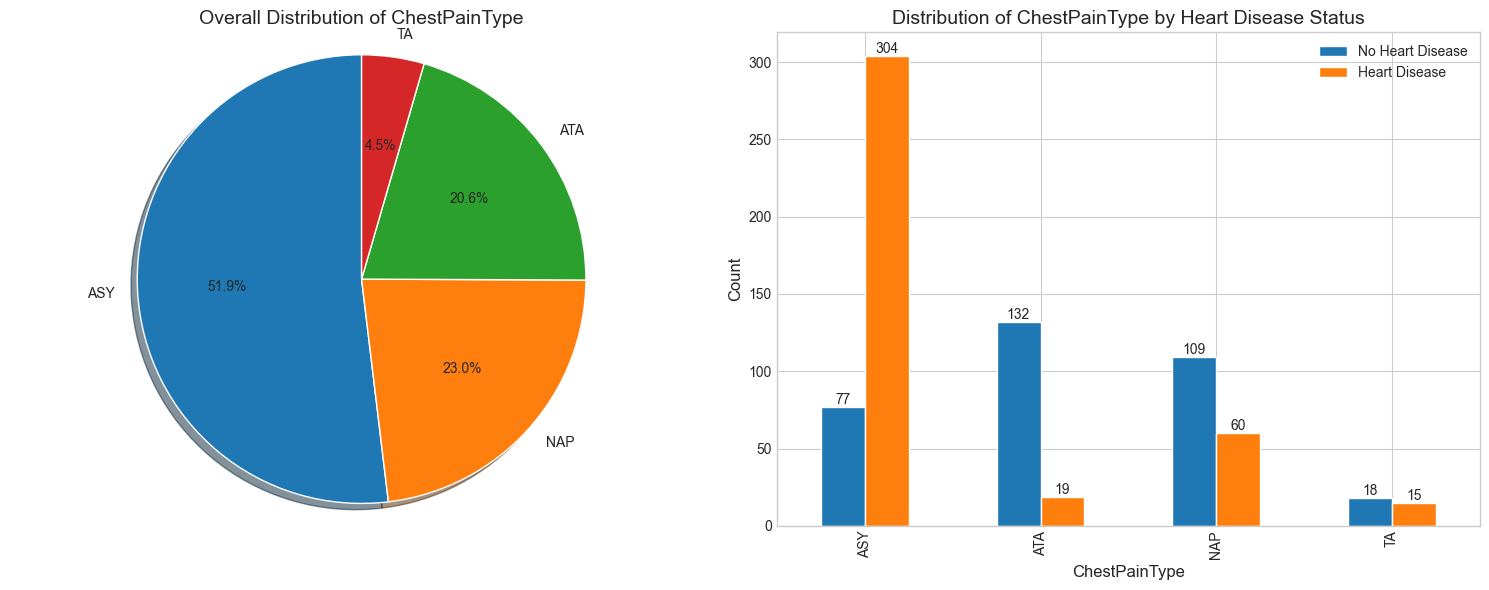

Contingency table for ChestPainType:
               No Heart Disease  Heart Disease
ChestPainType                                 
ASY                          77            304
ATA                         132             19
NAP                         109             60
TA                           18             15

Percentage within each category:
               No Heart Disease  Heart Disease
ChestPainType                                 
ASY                        20.2           79.8
ATA                        87.4           12.6
NAP                        64.5           35.5
TA                         54.5           45.5




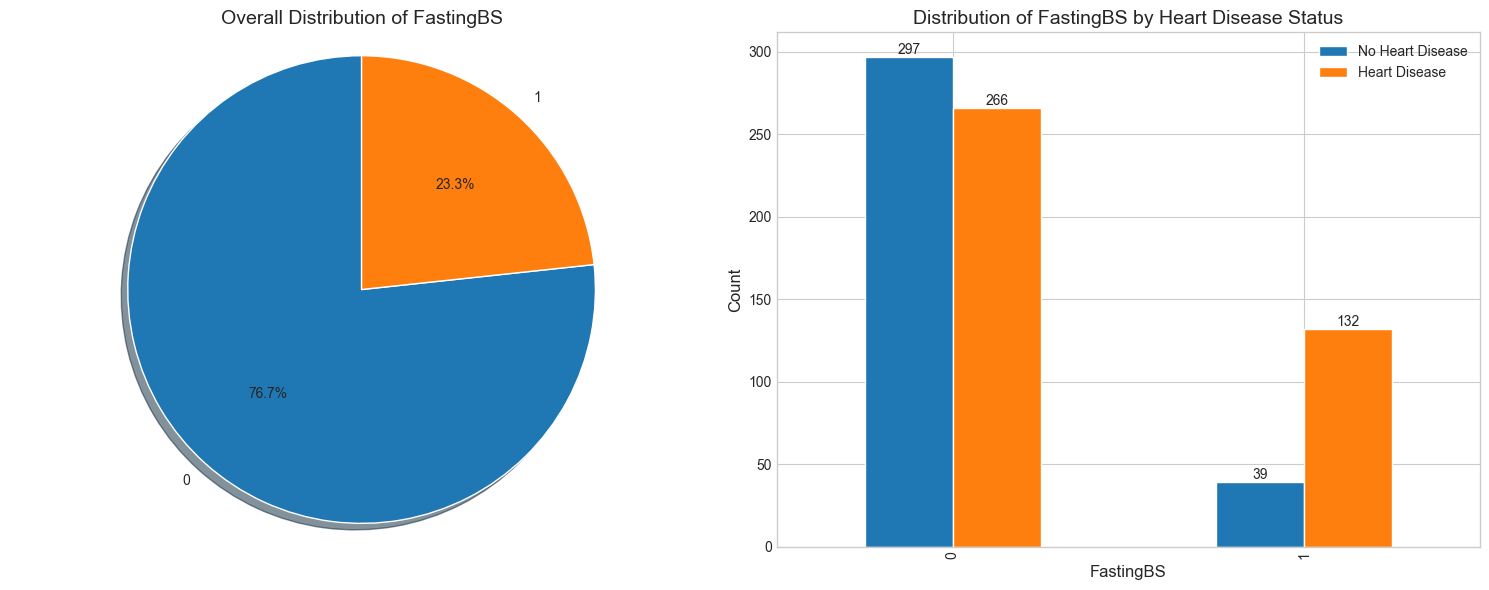

Contingency table for FastingBS:
           No Heart Disease  Heart Disease
FastingBS                                 
0                       297            266
1                        39            132

Percentage within each category:
           No Heart Disease  Heart Disease
FastingBS                                 
0                      52.8           47.2
1                      22.8           77.2




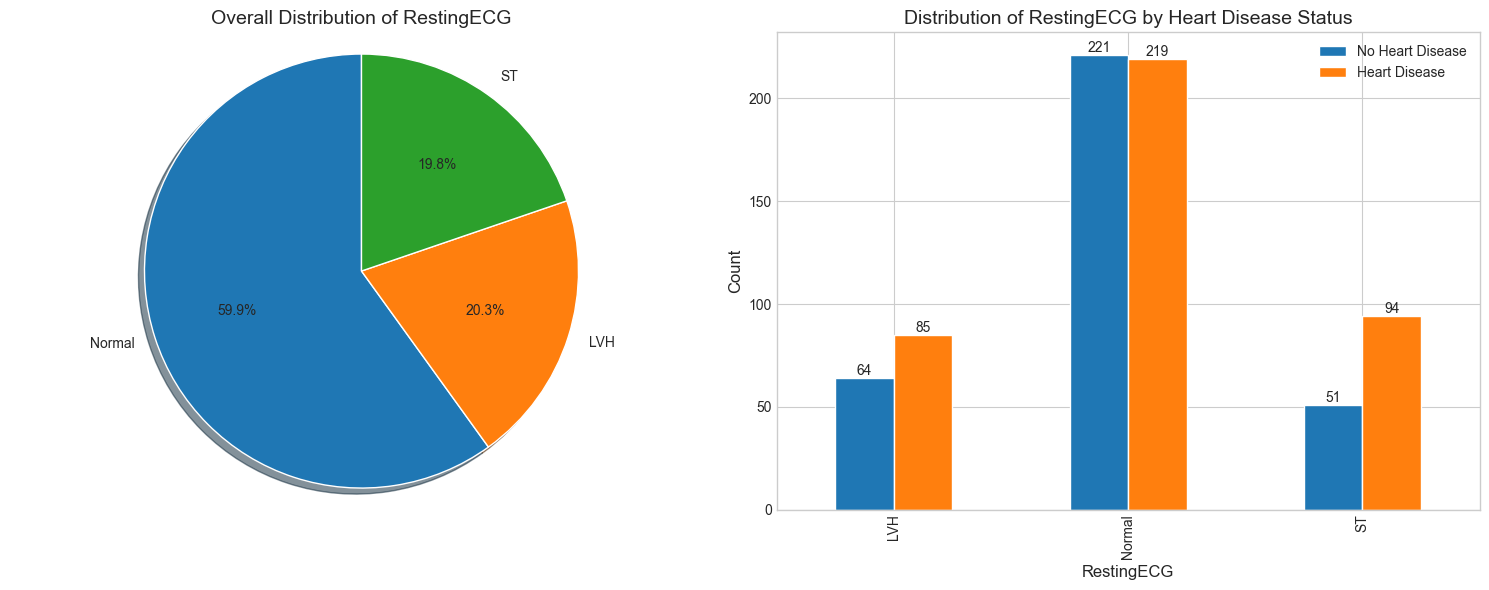

Contingency table for RestingECG:
            No Heart Disease  Heart Disease
RestingECG                                 
LVH                       64             85
Normal                   221            219
ST                        51             94

Percentage within each category:
            No Heart Disease  Heart Disease
RestingECG                                 
LVH                     43.0           57.0
Normal                  50.2           49.8
ST                      35.2           64.8




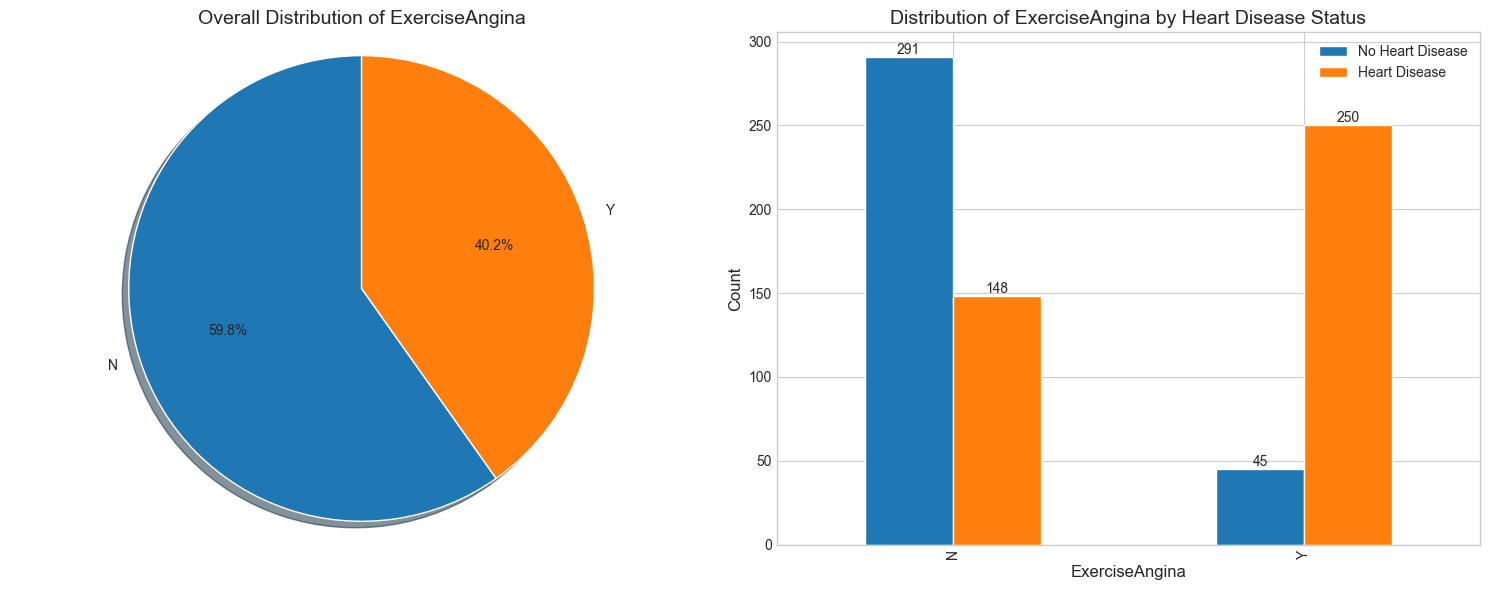

Contingency table for ExerciseAngina:
                No Heart Disease  Heart Disease
ExerciseAngina                                 
N                            291            148
Y                             45            250

Percentage within each category:
                No Heart Disease  Heart Disease
ExerciseAngina                                 
N                           66.3           33.7
Y                           15.3           84.7




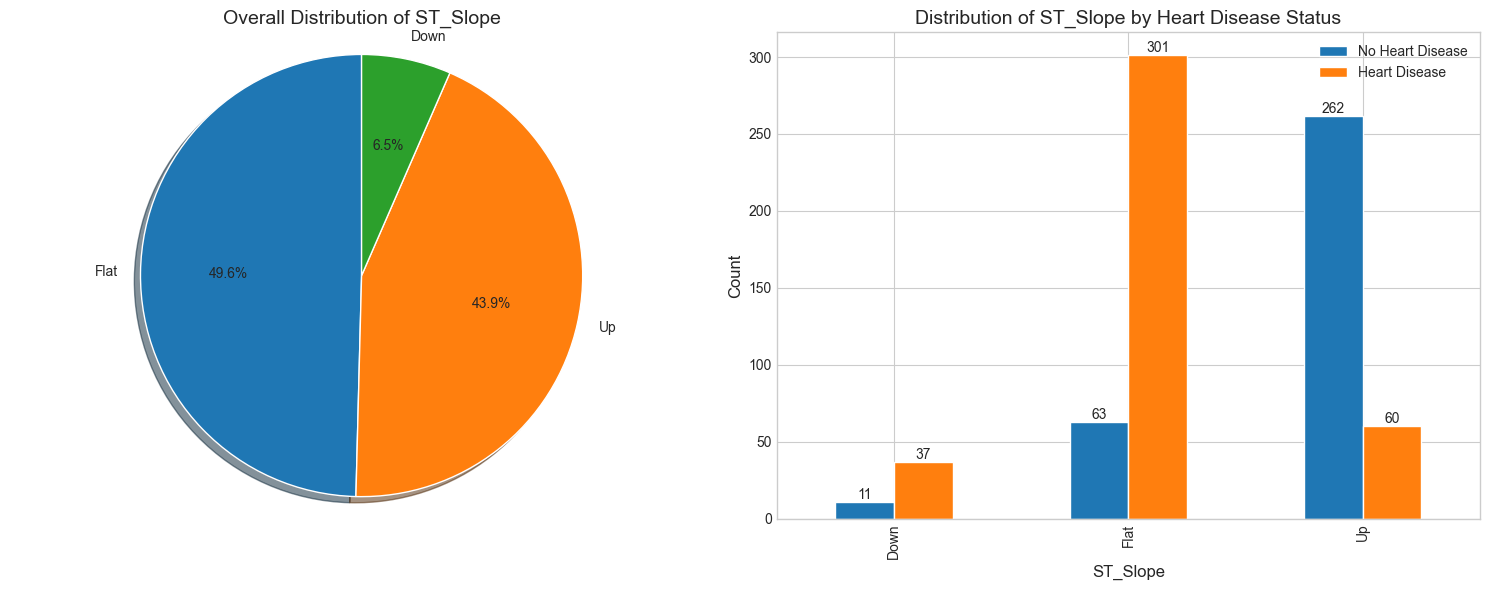

Contingency table for ST_Slope:
          No Heart Disease  Heart Disease
ST_Slope                                 
Down                    11             37
Flat                    63            301
Up                     262             60

Percentage within each category:
          No Heart Disease  Heart Disease
ST_Slope                                 
Down                  22.9           77.1
Flat                  17.3           82.7
Up                    81.4           18.6




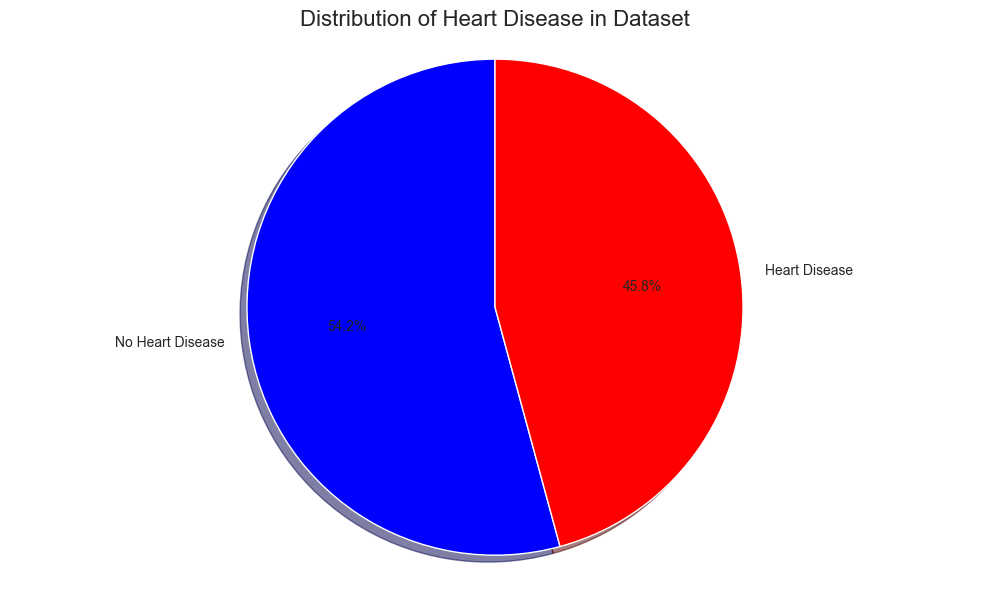

Heart disease distribution:
No Heart Disease (0): 336 samples (45.8%)
Heart Disease (1): 398 samples (54.2%)




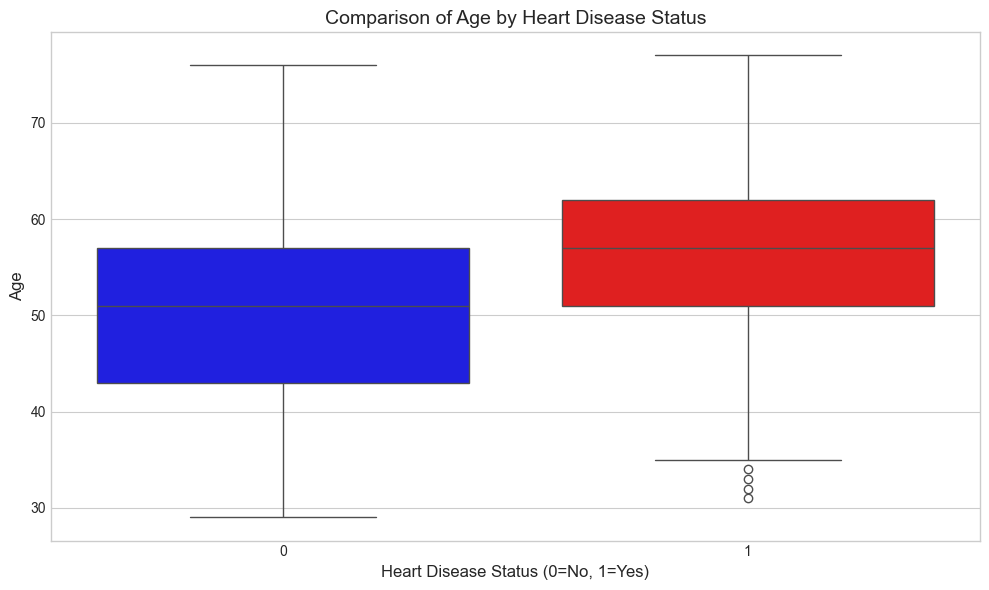

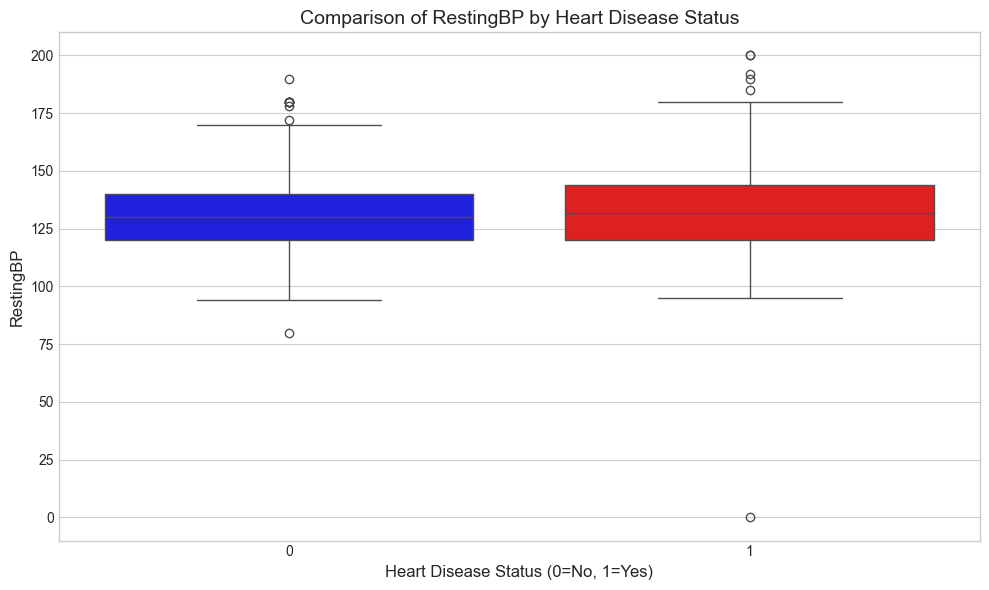

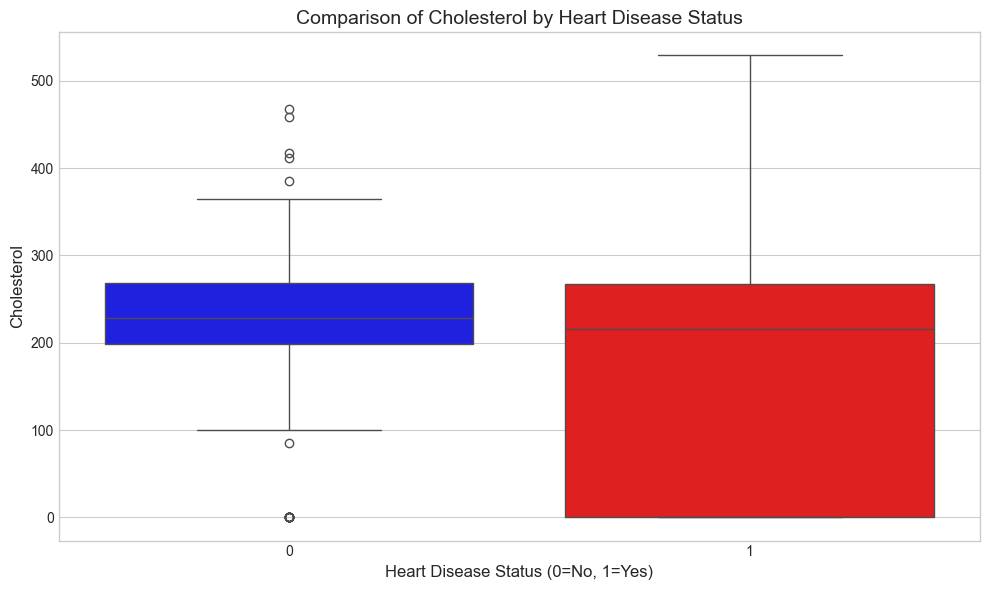

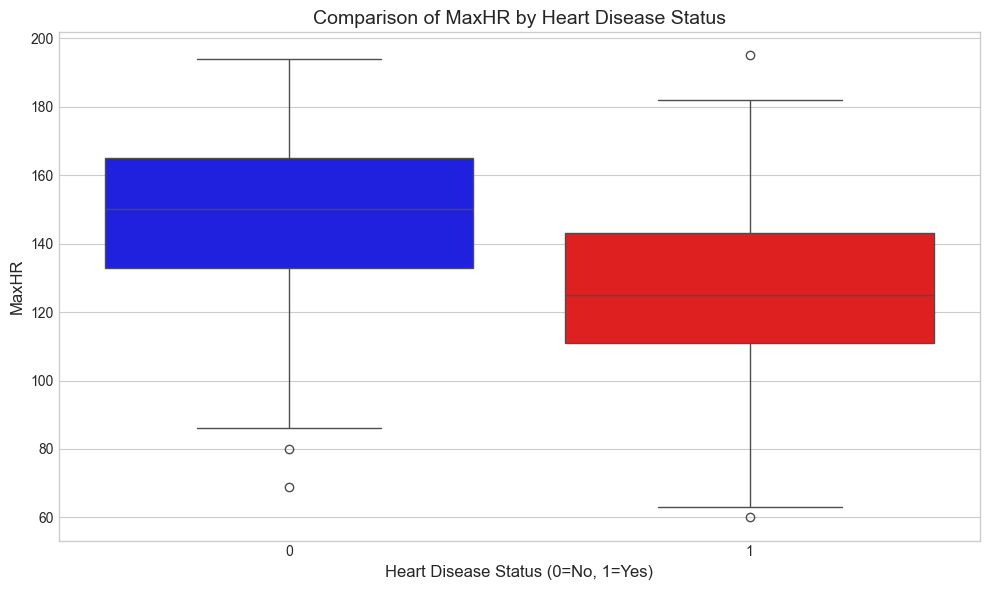

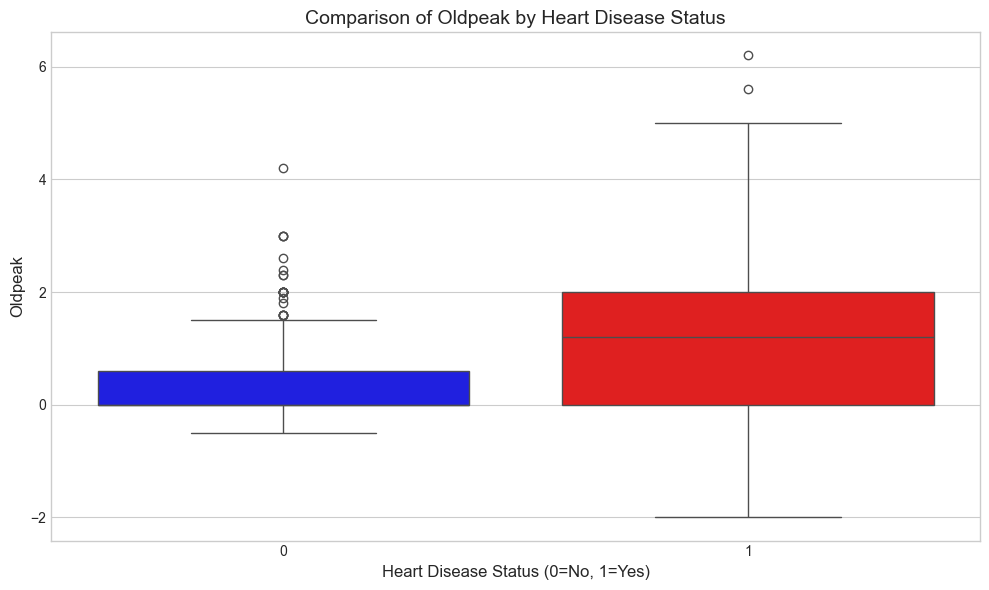

In [25]:
plot_numerical_features(train_df, numerical_features)
plot_categorical_features(train_df, [f for f in categorical_features if f != 'HeartDisease'])
plot_target_distribution(train_df)
plot_numerical_boxplots(train_df, numerical_features)

# Correlation
train_df_encoded = pd.get_dummies(train_df, columns=[f for f in categorical_features if f != 'HeartDisease']) #one-hot encoding
plt.figure(figsize=(12, 10))
corr_matrix = train_df_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, annot=False, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('analysis_heart/correlation_matrix.png', dpi=300)
plt.close()

target_corr = corr_matrix['HeartDisease'].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Feature Correlation with Heart Disease', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.tight_layout()
plt.savefig('analysis_heart/target_correlation.png', dpi=300)
plt.close()

We observe the following: 
* numerical features are roughly Gaussian distributed, with the exceptions: Age being bimodal, Cholesterol having a huge number of missing measurements
* categorical features: categories not evenly present; distribution differs with different feature and heart disease status
* ST_Slope mostly "Flat" for Heart-Disease records, mostly "Up" for no Heart-Disease records
* being Male seems to be highly correlated with Heart Disease
* ChestPain Type "ASY", (asymptomatic) seems to be highly correlated with Heart Disease 

Next, we preprocess the data. 
* First, missing values only appear for the variables "Cholesterol" and "RestingBP". Thus, we convert suspicious zeros to NaN and use an imputation technique: KNN imputation is recommended for medical datasets because it preserves relationships between features by using similar patients' data to estimate missing values. We verify that the distribution of imputed values matches the original data distribution to avoid introducing bias.
* To address the class imbalance between heart disease (HD) and non-heart disease records, we apply the resampling techniques SMOTE (Synthetic Minority Over-sampling Technique) that creates synthetic examples of the minority class (HD) by interpolating between existing samples.
* Categorical values are being one-hot encoded
* Numerical features are standardized 
* Scaling is applied to the test set (with the same mean, std-dev of the train/val set!).


In [9]:
train_processed = train_df.copy(deep=True)
test_processed = test_df.copy(deep=True)

In [10]:
# --- Suspicious zero values in training data ---
for feature in ['Cholesterol', 'RestingBP']:
    zeros_count = (train_processed[feature] == 0).sum()
    zeros_percent = (zeros_count / len(train_processed)) * 100
    print(f"{feature}: {zeros_count} zeros ({zeros_percent:.2f}%)")

# Convert suspicious zeros to NaN
for feature in ['Cholesterol', 'RestingBP']:
    train_processed.loc[train_processed[feature] == 0, feature] = np.nan
    test_processed.loc[test_processed[feature] == 0, feature] = np.nan

Cholesterol: 141 zeros (19.21%)
RestingBP: 1 zeros (0.14%)


In [11]:
# Split features and target before preprocessing
X_train = train_processed.drop(target, axis=1)
y_train = train_processed[target]
X_test = test_processed.drop(target, axis=1)
y_test = test_processed[target]

In [12]:
# One-hot encoding categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(X_train[categorical_features])

# Transform training data
encoded_cats_train = encoder.transform(X_train[categorical_features])
encoded_cats_df_train = pd.DataFrame(
    encoded_cats_train,
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_train.index
)

# Transform test data
encoded_cats_test = encoder.transform(X_test[categorical_features])
encoded_cats_df_test = pd.DataFrame(
    encoded_cats_test,
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_test.index
)

X_train_numerical = X_train[numerical_features].reset_index(drop=True)
X_test_numerical = X_test[numerical_features].reset_index(drop=True)

# Imputation
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train_numerical)

X_train_numerical_imputed = imputer.transform(X_train_numerical)
X_train_numerical_imputed_df = pd.DataFrame(
    X_train_numerical_imputed,
    columns=numerical_features,
    index=X_train_numerical.index
)
X_test_numerical_imputed = imputer.transform(X_test_numerical)
X_test_numerical_imputed_df = pd.DataFrame(
    X_test_numerical_imputed,
    columns=numerical_features,
    index=X_test_numerical.index
)
print("\nVerifying imputation results:")
for feature in ['Cholesterol', 'RestingBP']:
    original_mean = X_train[feature].dropna().mean()
    imputed_mean = X_train_numerical_imputed_df[feature].mean()
    print(f"{feature} - Original mean: {original_mean:.2f}, Imputed mean: {imputed_mean:.2f}")
    
# Standardization
scaler = StandardScaler()
scaler.fit(X_train_numerical_imputed_df)

# Scale training data, scale test data (using train set params)
X_train_numerical_scaled = scaler.transform(X_train_numerical_imputed_df)
X_train_numerical_scaled_df = pd.DataFrame(
    X_train_numerical_scaled,
    columns=numerical_features,
    index=X_train_numerical_imputed_df.index
)
X_test_numerical_scaled = scaler.transform(X_test_numerical_imputed_df)
X_test_numerical_scaled_df = pd.DataFrame(
    X_test_numerical_scaled,
    columns=numerical_features,
    index=X_test_numerical_imputed_df.index
)

# Combination
X_train_processed = pd.concat([X_train_numerical_scaled_df, encoded_cats_df_train], axis=1)
X_test_processed = pd.concat([X_test_numerical_scaled_df, encoded_cats_df_test], axis=1)

# Handle class-imbalance (with SMOTE)
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print(f"Class distribution percentage: {y_train.value_counts(normalize=True) * 100}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)


Verifying imputation results:
Cholesterol - Original mean: 244.57, Imputed mean: 245.22
RestingBP - Original mean: 132.24, Imputed mean: 132.23
Class distribution before SMOTE:
HeartDisease
1    398
0    336
Name: count, dtype: int64
Class distribution percentage: HeartDisease
1    54.223433
0    45.776567
Name: proportion, dtype: float64


/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Class distribution before SMOTE:
HeartDisease
1    398
0    336
Name: count, dtype: int64
Class distribution percentage: HeartDisease
1    54.223433
0    45.776567
Name: proportion, dtype: float64

Class distribution after SMOTE:
Counter({0: 398, 1: 398})
New training data shape: (796, 15)


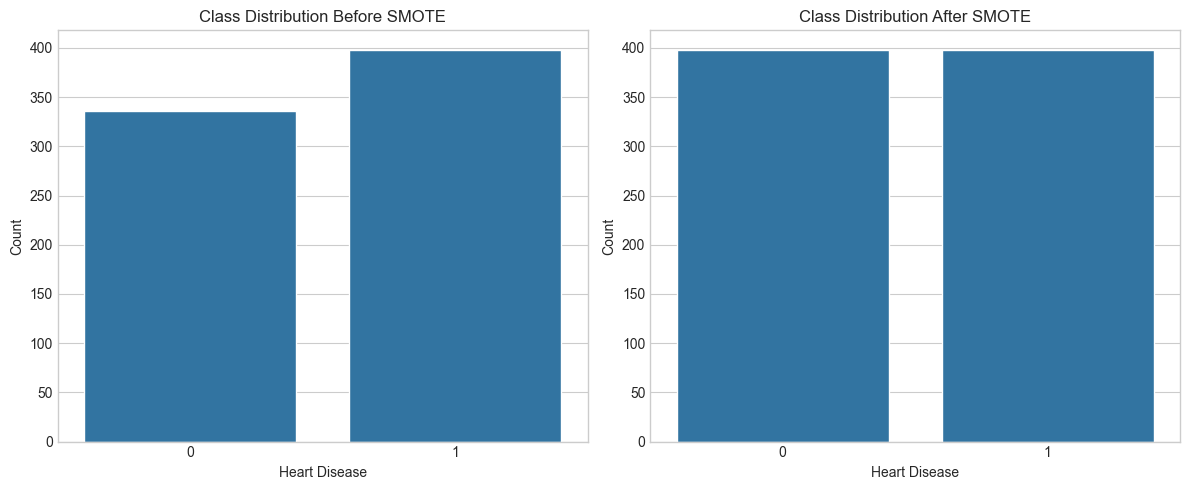

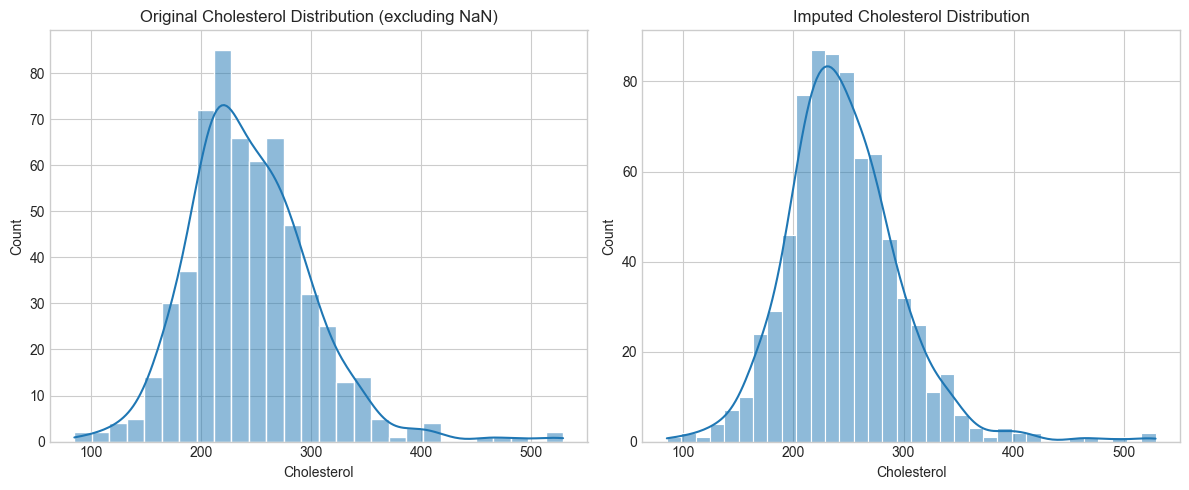

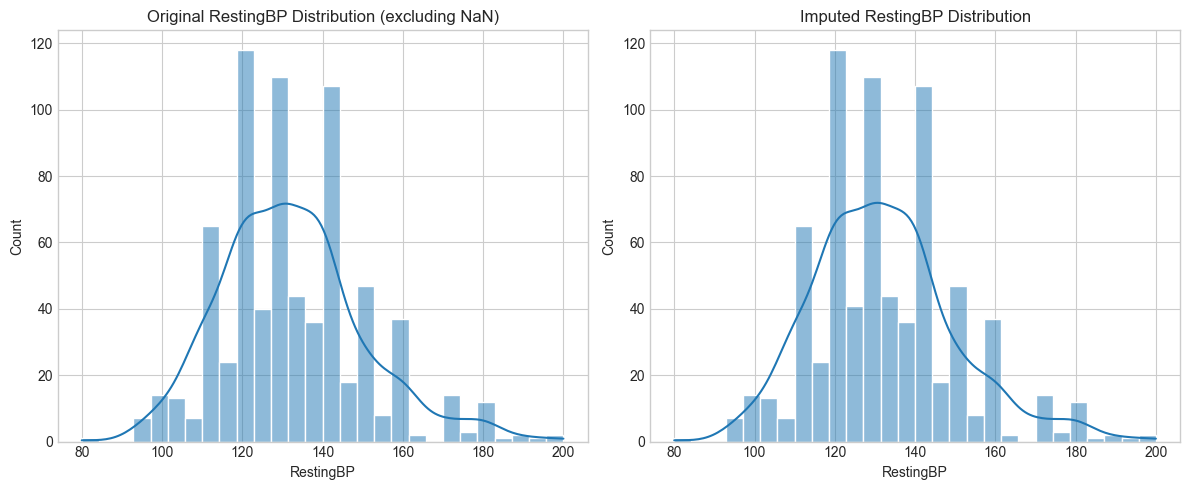


Final preprocessed data shapes:
X_train_resampled: (796, 15)
y_train_resampled: (796,)
X_test_processed: (184, 15)
y_test: (184,)


In [13]:
# Verify rebalancing
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print(f"Class distribution percentage: {y_train.value_counts(normalize=True) * 100}")

print("\nClass distribution after SMOTE:")
print(Counter(y_train_resampled))
print(f"New training data shape: {X_train_resampled.shape}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Heart Disease')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Heart Disease')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('data/class_distribution_comparison.png')
plt.show()

for feature in ['Cholesterol', 'RestingBP']:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(X_train[feature].dropna(), kde=True)
    plt.title(f'Original {feature} Distribution (excluding NaN)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(X_train_numerical_imputed_df[feature], kde=True)
    plt.title(f'Imputed {feature} Distribution')
    
    plt.tight_layout()
    plt.savefig(f'data/{feature}_imputation_comparison.png')
    plt.show()

print("\nFinal preprocessed data shapes:")
print(f"X_train_resampled: {X_train_resampled.shape}")
print(f"y_train_resampled: {y_train_resampled.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"y_test: {y_test.shape}")

In [14]:
# Save preprocessed data
X_train_resampled.to_csv('data/processed_data/X_train_processed.csv', index=False)
pd.DataFrame(y_train_resampled, columns=[target]).to_csv('data/processed_data/y_train_processed.csv', index=False)
X_test_processed.to_csv('data/processed_data/X_test_processed.csv', index=False)
y_test.to_csv('data/processed_data/y_test.csv', index=False)